In [1]:
import numpy as np
import nibabel as nib
import h5py
import pandas as pd
from scipy.ndimage.interpolation import zoom

from config import doc_dir, indices_holdout

/home/fabiane/anaconda2/envs/mort/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
doc_dir

'/analysis/share/Ritter/MS/Test/file_list_HC_MS_BET_FLAIR.csv'

In [3]:
output_shape = (96, 114, 96)
z_factor=0.525

In [4]:
df = pd.read_csv(doc_dir)

In [5]:
df.head()

,file,label,name,path,time
0,VIMS_MS_027_1_FLAIR.nii.gz,MS,VIMS_MS_027,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_02...,1.0
1,VIMS_MS_043_1_FLAIR.nii.gz,MS,VIMS_MS_043,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
2,VIMS_MS_141_1_FLAIR.nii.gz,MS,VIMS_MS_141,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_14...,1.0
3,VIMS_MS_137_1_FLAIR.nii.gz,MS,VIMS_MS_137,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_13...,1.0
4,VIMS_HC_022_1_FLAIR.nii.gz,HC,VIMS_HC_022,/analysis/share/Ritter/MS/CIS/02_HC/VIMS_HC_02...,1.0


In [6]:
# split datasets
holdout_df = df.iloc[indices_holdout]
train_df = df.drop(indices_holdout)

holdout_df.reset_index(inplace=True)
holdout_df = holdout_df.drop("index", axis="columns")
train_df.reset_index(inplace=True)
train_df = train_df.drop("index", axis="columns")

In [7]:
holdout_df.head()

,file,label,name,path,time
0,VIMS_MS_118_1_FLAIR.nii.gz,MS,VIMS_MS_118,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_11...,1.0
1,VIMS_MS_041_1_FLAIR.nii.gz,MS,VIMS_MS_041,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
2,VIMS_MS_132_1_FLAIR.nii.gz,MS,VIMS_MS_132,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_13...,1.0
3,RS_GK_002_1_FLAIR.nii.gz,HC,RS_GK_002,/analysis/share/Ritter/MS/CIS/02_HC/RS_GK_002/...,1.0
4,VIMS_MS_073_1_FLAIR.nii.gz,MS,VIMS_MS_073,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_07...,1.0


In [8]:
train_df.head()

,file,label,name,path,time
0,VIMS_MS_027_1_FLAIR.nii.gz,MS,VIMS_MS_027,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_02...,1.0
1,VIMS_MS_043_1_FLAIR.nii.gz,MS,VIMS_MS_043,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
2,VIMS_MS_141_1_FLAIR.nii.gz,MS,VIMS_MS_141,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_14...,1.0
3,VIMS_MS_137_1_FLAIR.nii.gz,MS,VIMS_MS_137,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_13...,1.0
4,VIMS_HC_022_1_FLAIR.nii.gz,HC,VIMS_HC_022,/analysis/share/Ritter/MS/CIS/02_HC/VIMS_HC_02...,1.0


In [9]:
print(len(train_df))
print(len(holdout_df))

124
23


In [10]:
(len(train_df), ) + output_shape

(124, 96, 114, 96)

In [11]:
# load images in matrix
def create_dataset(dataset, z_factor, output_shape):
    data_matrix = np.empty(shape=((len(dataset),) + output_shape))
    labels = np.empty(shape=((len(dataset),)))
    edss_scores = np.empty(shape=((len(dataset),)))
    for idx, row in dataset.iterrows():
        path = row["path"]
        scan = nib.load(path)
        struct_arr = scan.get_data().astype(np.float32)
        struct_arr = zoom(struct_arr, z_factor)
        data_matrix[idx] = struct_arr
        labels[idx] = (row["label"] == "MS") *1
        edss_scores[idx] = row["edss"]
    return data_matrix, labels, edss_scores

In [12]:
train_dataset, train_labels, train_edss = create_dataset(train_df, z_factor=z_factor, output_shape=output_shape)
holdout_dataset, holdout_labels, holdout_edss = create_dataset(holdout_df, z_factor=z_factor, output_shape=output_shape)

/home/fabiane/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [13]:
print(train_dataset.shape)
print(holdout_dataset.shape)

(124, 96, 114, 96)
(23, 96, 114, 96)


In [14]:
import matplotlib.pyplot as plt

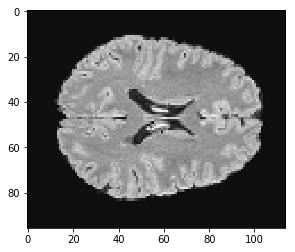

In [15]:
plt.imshow(train_dataset[-1][:,:,48], cmap='gray')
plt.show()

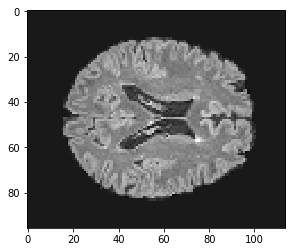

In [16]:
plt.imshow(holdout_dataset[-1][:,:,48], cmap='gray')
plt.show()

In [17]:
#h5 = h5py.File('/data/Ritter/MS/CIS/train_dataset.h5', 'w')
h5 = h5py.File('/analysis/fabiane/data/MS/explMS/train_dataset_with_edss.h5', 'w')
h5.create_dataset('X', data=train_dataset)
h5.create_dataset('y', data=train_labels)
h5.create_dataset('edss', data=train_edss)
h5.close()

In [18]:
#h5 = h5py.File('/data/Ritter/MS/CIS/holdout_dataset.h5', 'w')
h5 = h5py.File('/analysis/fabiane/data/MS/explMS/holdout_dataset_with_edss.h5', 'w')
h5.create_dataset('X', data=holdout_dataset)
h5.create_dataset('y', data=holdout_labels)
h5.create_dataset('edss', data=holdout_edss)
h5.close()